# Data processing tutorial
* In this tutorial, you will look at the processed 12-m data of your pulsars using python.
<br>
<br>
* First, we import the required libraries, modules and packages. We use PSRCHIVE python wrapper

In [1]:
#Ben Perera - 18 Dec 2022

%matplotlib notebook
import psrchive
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

* Read in your processed archive data file using PSRCHIVE

In [2]:
# your archive data file name
# we use the archive file of B1641-45 obtained
# with the AO 12-m telescope
fn = '20221204.B1641-45.ar'

# Read in the data archive
obs = psrchive.Archive_load(fn)

itoa_code no alias found for ARECIBO_12



* Now you can dedisperse, polarization sum, and remove the baseline of the data.


* Then you can extract the data chunck and store in the "data" array.


In [3]:
# desiperse the data
obs.dedisperse()

# sum polarization channels
obs.pscrunch()

# remove baseline
obs.remove_baseline()

* Extract the data and stored in `data` array. 


* Let's print the shape of the `data` array

In [4]:
#Import the data chunck and store in "data" array
data = obs.get_data()


#Shape of the "data" array
print('Shape of the data array:')
data.shape

Shape of the data array:


(180, 1, 256, 256)

* The `data` array has 4 dimensions: 


-first dimension: Number of Time sub-integrations. Each sub-integration is 10 sec.
<br>
-second dimension: Number of Polarization channels. We use the Total Intensity, so there is one Pol channel.
<br>
-third dimension: Number of Frequency channels. We chose 256 channels.
<br>
-fourth dimension: Number of Phase bins across the pulse profile. We used 256 phase bins.



In [5]:
nsub = data.shape[0]
nchan = data.shape[2]
nbins = data.shape[3]

tsub = 10.           #each time subint is 10 sec
f_low = 2192.        #lowest frequency channel
f_high = 2363.34     #highest frequency channel
ch_bw = (f_high - f_low)/(1.*nchan)     #BW of a frequency channel

# Apply weights to mask bad channels (i.e. weight = 0).
if nchan > 1:
    weights = obs.get_weights()
    for ww in range(nbins):
        data[:,0,:,ww] *= weights
        
# Flip the freq dimension to have Freq_low --> Freq_high
data = np.flip(data, axis=2)

## Plot subintegrations

* Let's plot the profiles of sub-integrations


* In order to do that, we need to average all frequency channels.

<IPython.core.display.Javascript object>


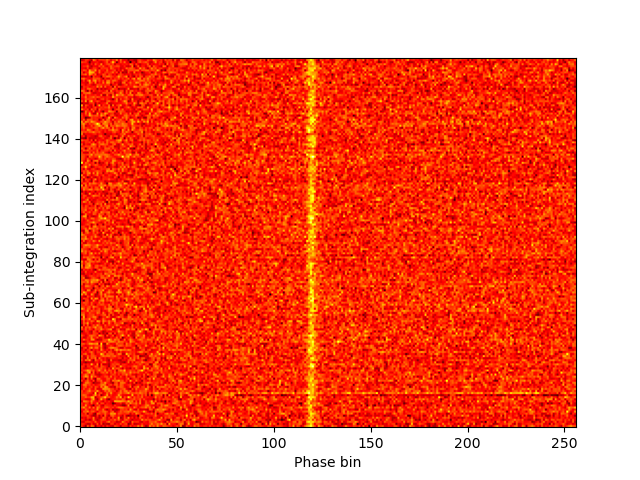

In [6]:
subint_profs = np.mean(data, axis=2)[:,0,:]

plt.figure()
plt.xlim(0,nbins)
plt.xlabel('Phase bin')
plt.ylabel('Sub-integration index')
plt.imshow(subint_profs, aspect='auto', origin='lower',cmap='hot',)

## Plot the time-averaged profiles in Freq channels across the bandwidth

* Let's plot the time-averaged profiles across the bandwidth


* In order to do that, we need to average all the subintegrations.

<IPython.core.display.Javascript object>


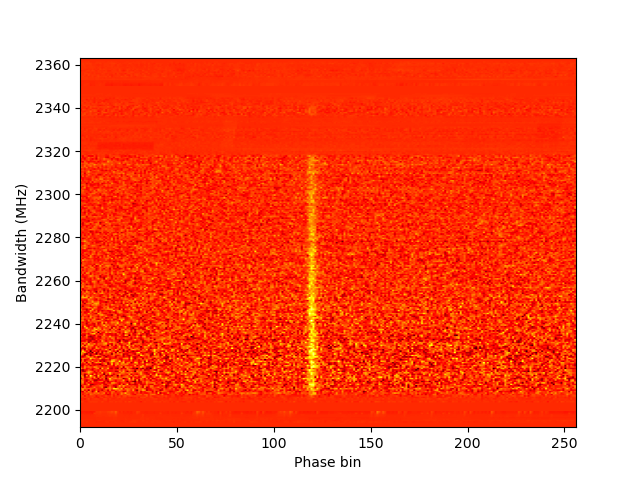

In [7]:
freq_profs = np.mean(data, axis=0)[0,:,:]

plt.figure()
plt.xlim(0,nbins)
plt.xlabel('Phase bin')
plt.ylabel('Bandwidth (MHz)')
plt.imshow(freq_profs, aspect='auto', origin='lower',cmap='hot',extent=[0,nbins,f_low,f_high])

## Get the pulse profile of the pulsar

* Let's plot the integrated (or averaged) pulse profile. 


* In order to do that, we need to average all frequency channels and time sub-integrations.

<IPython.core.display.Javascript object>


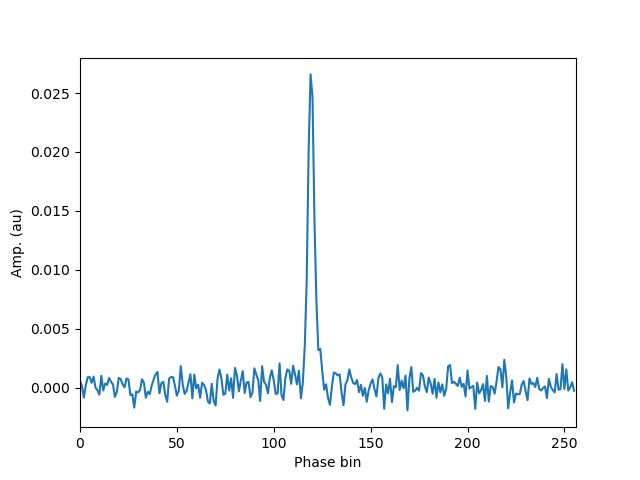

In [8]:
prof = np.mean(np.mean(data, axis=2), axis=0)[0,:]

plt.figure()
plt.xlim(0,nbins)
plt.xlabel('Phase bin')
plt.ylabel('Amp. (au)')
plt.plot(np.arange(nbins), prof)

## Estimate the Mean flux density of the observation

* Since we do not have an observed flux calibrator, let's use the 12-m parameters to estimate the mean flux density.


* We simply estimate the noise fluctuation using $\Delta S =  \frac{T_{sys}}{G\sqrt{n_{pol}T_{obs} \Delta f}}$. If $\Delta f$ is in MHz and $t_{obs}$ is in sec, then we find $\Delta S$ is in mJy.


In [9]:
# Estimate the noise fluctuation in Jy
# To do that, we need Tsys (in K) and the Gain (in K/Jy) of the telescope (SEFD = Tsys/Gain)
tsys = 123.
gain = 0.029

# No. of Pol channels
npol = 2

# bandwidth in MHz
bw = 110

# Observation length in sec
tobs = 1800

# Estimate \DeltaS first
delta_s = tsys/(gain * np.sqrt(npol * (tobs/nbins) * bw))
                
print('\nNoise fluctuation (mJy) = ', delta_s)


Noise fluctuation (mJy) =  107.83990664570835




* Then scale the Pulse profile using the noise fluctuation, $\Delta S = C \sigma_p$, where $C$ is the scaling factor and $\sigma_p$ is the off-pulse standard deviation.



In [10]:
# To estimate the scaling factor, we first need to get the off-pulse standard deviation.
# select the off-pulse region
off_pulse1 = prof[0:105]
off_pulse2 = prof[140:255]
off_pulse = np.concatenate((off_pulse1,off_pulse2))

# off-pulse standard deviation
off_std = np.std(off_pulse)

print('\nOff-pulse std = ', off_std)


Off-pulse std =  0.0008197994


In [11]:
# estimate the scaling factor now!
scale_fact = delta_s/off_std

print('Flux density scaling factor C (mJy) = ', scale_fact)


Flux density scaling factor C (mJy) =  131544.265688144


## Plot the pulse profile in mJy units

* Now multiply the pulse profile by the scaling factor $C$.


* Then plot the profile in mJy.

<IPython.core.display.Javascript object>


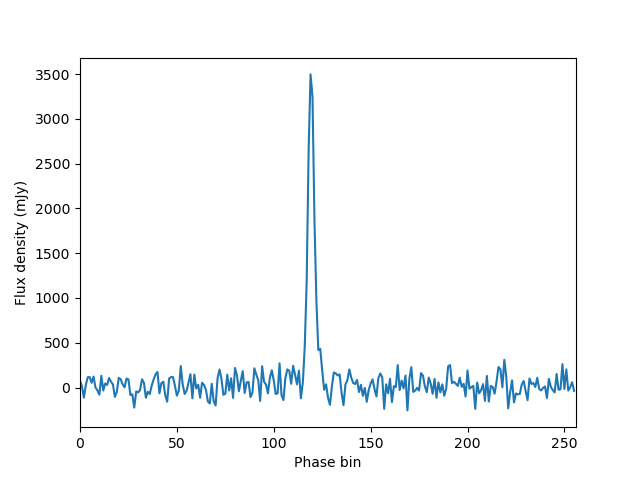

In [12]:
# scale the profile in mJy
prof_mjy = prof * scale_fact

plt.figure()
plt.xlim(0,nbins)
plt.xlabel('Phase bin')
plt.ylabel('Flux density (mJy)')
plt.plot(np.arange(nbins), prof_mjy)

## Estimate the Peak and Mean flux densities

In [13]:
# peak flux density
s_peak = np.amax(prof_mjy)
print('\nPeak flux density (mJy) = ', s_peak)

# mean flux density
s_mean = np.sum(prof_mjy)/nbins
print('\nMean flux density (mJy) = ', s_mean)

# Error of the mean flux density
s_mean_err = off_std * scale_fact / np.sqrt(nbins)
print('\nMean flux density error (mJy) = ', s_mean_err)


Peak flux density (mJy) =  3497.2349

Mean flux density (mJy) =  80.97129821777344

Mean flux density error (mJy) =  6.739994165356771


## Estimate the Spectral index of the pulsar

* We need flux densities measured at multiple frequencies.


* You can get flux densities from the ATNF pulsar catalog.

In [14]:
# known flux densities of the pulsar from ATNF
fluxes = [1040, 300, s_mean, 30]
freqs = [800, 1400, (f_high+f_low)/2., 5000]
fluxes_err = [60, 60, s_mean_err, 6]

* Make the plot - Flux density vs Freq

<IPython.core.display.Javascript object>


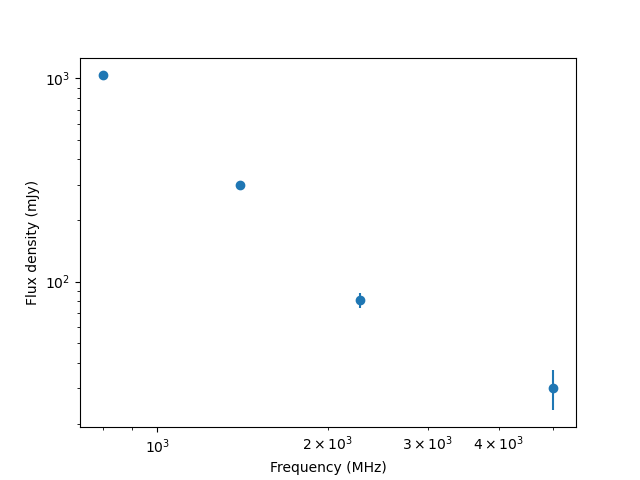

<ErrorbarContainer object of 3 artists>

In [15]:
plt.figure()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Flux density (mJy)')
plt.errorbar(freqs, fluxes, yerr=s_mean_err, linestyle='', marker='o')

## Estimate the spectral index of the pulsar

* We need to fit a straight line to the data points



In [16]:
# define the function for straight line (Y = M*x + C)
def func_st(x, m, c):
    return m * x + c

# fit a stright line 
popt, pcov = curve_fit(func_st, np.log10(freqs), np.log10(fluxes), sigma=np.log10(fluxes_err))
perr = np.sqrt(np.diag(pcov))

slope = popt[0]
slope_err = perr[0]

inter = popt[1]
inter_err = perr[1]

# Spectral index
print("\n****************\n")
print('\nSpectral index = ', slope, '+/-', slope_err)
print("\n****************\n")


****************


Spectral index =  -1.7742820813726623 +/- 0.2827516067897863

****************



<IPython.core.display.Javascript object>


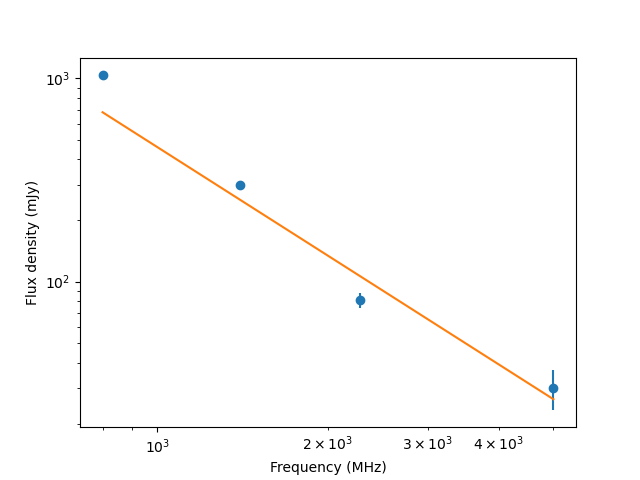

In [17]:
#plot the best-fitted line on the the plot
line = func_st(np.log10(freqs), slope, inter)

plt.figure()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Flux density (mJy)')
plt.errorbar(freqs, fluxes, yerr=s_mean_err, linestyle='', marker='o')
plt.plot(freqs, 10**line)